In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow
!pip install imblearn
!pip install opencv-python

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
#from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2
from tensorflow.keras.utils import to_categorical

In [4]:
data = pd.read_csv('/content/drive/MyDrive/dataset/fer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


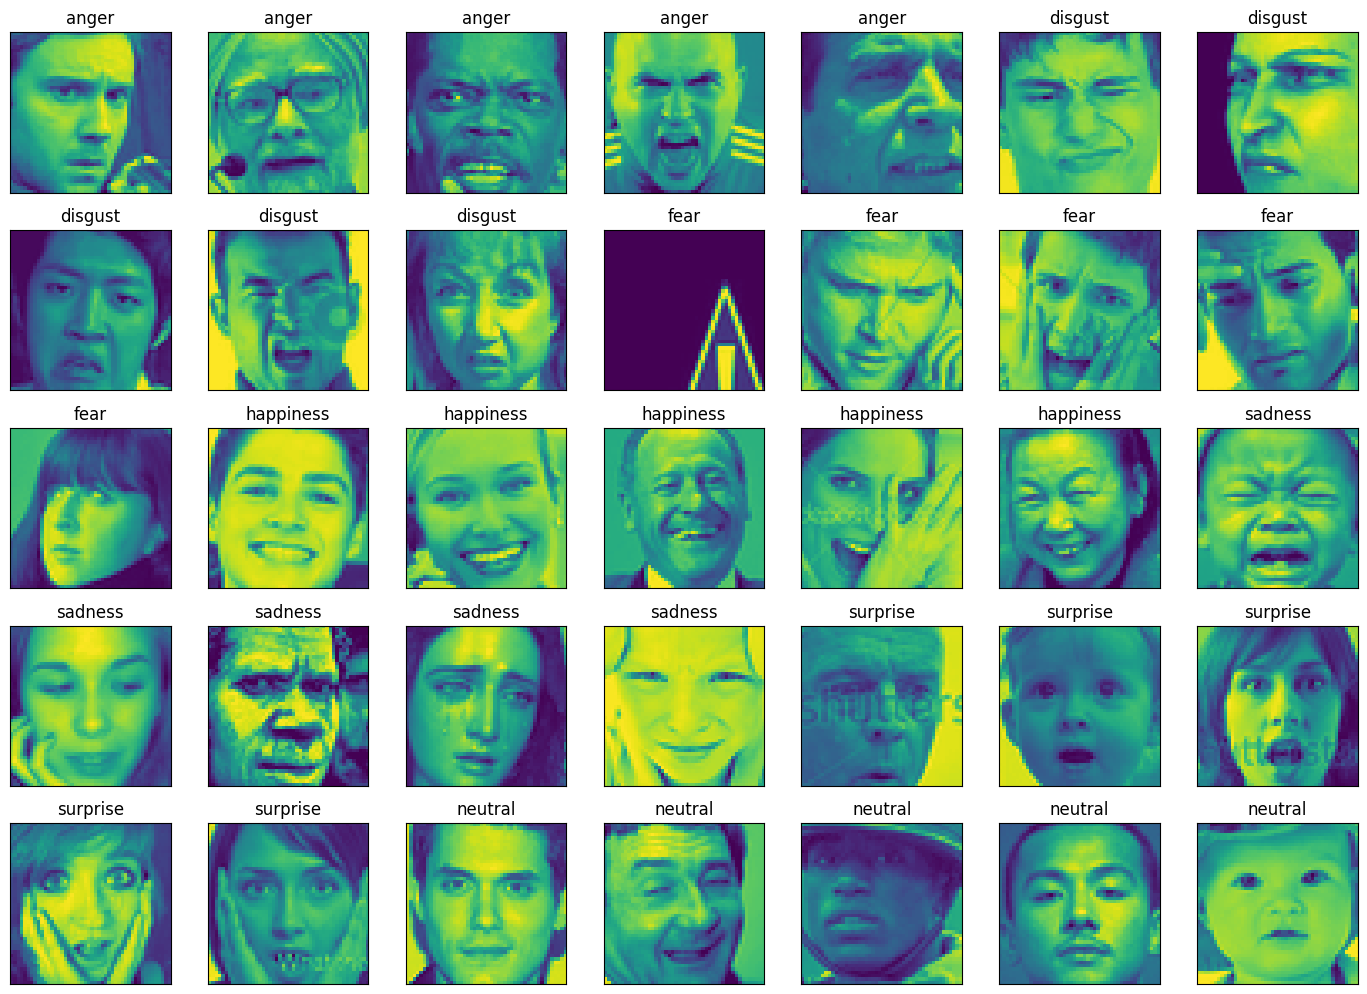

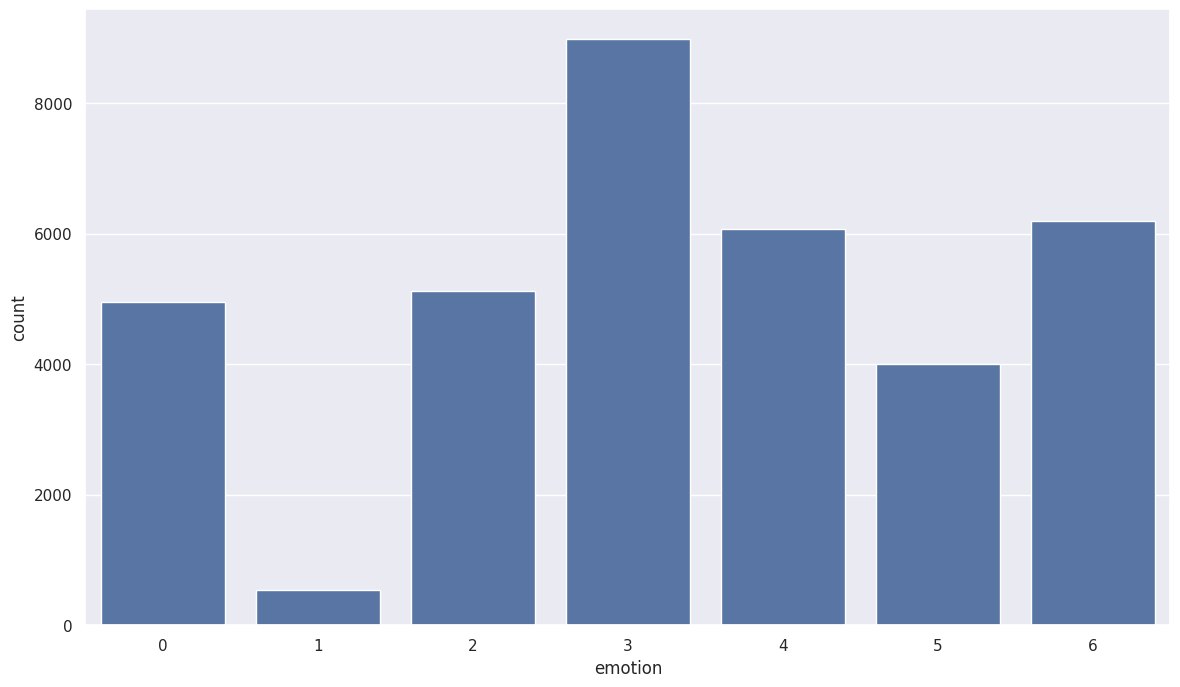

In [5]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [6]:
# Split the data into feature & target variable
x_data = data['pixels']
y_data = data['emotion']

In [7]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)


y_data.value_counts()


(62923, 1)   (62923,)


,count
emotion,
0,8989
2,8989
4,8989
6,8989
3,8989
5,8989
1,8989


In [8]:
x_data = pd.Series(x_data.flatten())
x_data

# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [9]:

y_train = to_categorical(y_train, 7)
y_train.shape
y_test = to_categorical(y_test, 7)
y_test.shape
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 7), (6293, 7))

In [10]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(256, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(128, activation='relu'),
    Dropout(0.25),

     Dense(256, activation='relu'),
    Dropout(0.2),

    # Output Layer
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,115,975 (4.26 MB)

 Trainable params: 1,114,695 (4.25 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [11]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
x_train.shape, x_test.shape, y_train.shape, y_test.shape

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Set up to save best model
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Train again, but now with checkpoint
history = model.fit(
    x_train, y_train,
    epochs=60,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint]
)


Epoch 1/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9552 - loss: 0.1289
Epoch 1: val_accuracy improved from -inf to 0.84570, saving model to /content/drive/MyDrive/best_model.h5


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9552 - loss: 0.1289 - val_accuracy: 0.8457 - val_loss: 0.6514
Epoch 2/60
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9559 - loss: 0.1260
Epoch 2: val_accuracy improved from 0.84570 to 0.85015, saving model to /content/drive/MyDrive/best_model.h5


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.9559 - loss: 0.1260 - val_accuracy: 0.8502 - val_loss: 0.7025
Epoch 3/60
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9562 - loss: 0.1267
Epoch 3: val_accuracy did not improve from 0.85015
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9562 - loss: 0.1267 - val_accuracy: 0.8444 - val_loss: 0.6593
Epoch 4/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9572 - loss: 0.1200
Epoch 4: val_accuracy improved from 0.85015 to 0.85222, saving model to /content/drive/MyDrive/best_model.h5


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9572 - loss: 0.1200 - val_accuracy: 0.8522 - val_loss: 0.6464
Epoch 5/60
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9554 - loss: 0.1248
Epoch 5: val_accuracy improved from 0.85222 to 0.85381, saving model to /content/drive/MyDrive/best_model.h5


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9554 - loss: 0.1248 - val_accuracy: 0.8538 - val_loss: 0.6883
Epoch 6/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9607 - loss: 0.1127
Epoch 6: val_accuracy did not improve from 0.85381
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9607 - loss: 0.1127 - val_accuracy: 0.8503 - val_loss: 0.7024
Epoch 7/60
1768/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9593 - loss: 0.1125
Epoch 7: val_accuracy did not improve from 0.85381
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9593 - loss: 0.1125 - val_accuracy: 0.8538 - val_loss: 0.6939
Epoch 8/60
1767/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9586 - loss: 0.1158
Epoch 8: val_accuracy did not improve from 0.85381
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9586 - loss: 0.1158 - val_accuracy: 0.8444 - val_loss: 0.6990
Epoch 9/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9632 - loss: 0.1067
Epoch 9

1770/1770 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.9668 - loss: 0.0945 - val_accuracy: 0.8551 - val_loss: 0.6771
Epoch 15/60
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9669 - loss: 0.0936
Epoch 15: val_accuracy did not improve from 0.85508
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9669 - loss: 0.0936 - val_accuracy: 0.8530 - val_loss: 0.7312
Epoch 16/60
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9675 - loss: 0.0913
Epoch 16: val_accuracy did not improve from 0.85508
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9675 - loss: 0.0913 - val_accuracy: 0.8521 - val_loss: 0.6942
Epoch 17/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9671 - loss: 0.0926
Epoch 17: val_accuracy did not improve from 0.85508
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9671 - loss: 0.0926 - val_accuracy: 0.8525 - val_loss: 0.7455
Epoch 18/60
1768/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9689 - loss: 0.0903


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.9689 - loss: 0.0903 - val_accuracy: 0.8576 - val_loss: 0.7108
Epoch 19/60
1768/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9698 - loss: 0.0869
Epoch 19: val_accuracy did not improve from 0.85762
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - accuracy: 0.9698 - loss: 0.0869 - val_accuracy: 0.8513 - val_loss: 0.7141
Epoch 20/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9699 - loss: 0.0882
Epoch 20: val_accuracy did not improve from 0.85762
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9699 - loss: 0.0882 - val_accuracy: 0.8463 - val_loss: 0.7246
Epoch 21/60
1768/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9696 - loss: 0.0857
Epoch 21: val_accuracy improved from 0.85762 to 0.85969, saving model to /content/drive/MyDrive/best_model.h5


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.9696 - loss: 0.0857 - val_accuracy: 0.8597 - val_loss: 0.7786
Epoch 22/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9723 - loss: 0.0823
Epoch 22: val_accuracy did not improve from 0.85969
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9723 - loss: 0.0823 - val_accuracy: 0.8530 - val_loss: 0.7544
Epoch 23/60
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9699 - loss: 0.0827
Epoch 23: val_accuracy did not improve from 0.85969
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9699 - loss: 0.0827 - val_accuracy: 0.8549 - val_loss: 0.7383
Epoch 24/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9690 - loss: 0.0901
Epoch 24: val_accuracy did not improve from 0.85969
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9690 - loss: 0.0901 - val_accuracy: 0.8543 - val_loss: 0.7280
Epoch 25/60
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9734 - loss: 0.0776


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.9752 - loss: 0.0715 - val_accuracy: 0.8603 - val_loss: 0.7197
Epoch 33/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9754 - loss: 0.0722
Epoch 33: val_accuracy did not improve from 0.86032
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.9754 - loss: 0.0722 - val_accuracy: 0.8514 - val_loss: 0.7523
Epoch 34/60
1767/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9761 - loss: 0.0705
Epoch 34: val_accuracy improved from 0.86032 to 0.86112, saving model to /content/drive/MyDrive/best_model.h5


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9761 - loss: 0.0705 - val_accuracy: 0.8611 - val_loss: 0.7497
Epoch 35/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9776 - loss: 0.0657
Epoch 35: val_accuracy did not improve from 0.86112
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9776 - loss: 0.0657 - val_accuracy: 0.8552 - val_loss: 0.7507
Epoch 36/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9779 - loss: 0.0663
Epoch 36: val_accuracy improved from 0.86112 to 0.86207, saving model to /content/drive/MyDrive/best_model.h5


1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9779 - loss: 0.0663 - val_accuracy: 0.8621 - val_loss: 0.7508
Epoch 37/60
1767/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9772 - loss: 0.0664
Epoch 37: val_accuracy did not improve from 0.86207
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9772 - loss: 0.0664 - val_accuracy: 0.8533 - val_loss: 0.7331
Epoch 38/60
1768/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9787 - loss: 0.0602
Epoch 38: val_accuracy did not improve from 0.86207
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.9787 - loss: 0.0602 - val_accuracy: 0.8489 - val_loss: 0.8134
Epoch 39/60
1768/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9773 - loss: 0.0668
Epoch 39: val_accuracy did not improve from 0.86207
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9773 - loss: 0.0668 - val_accuracy: 0.8573 - val_loss: 0.7420
Epoch 40/60
1769/1770 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9782 - loss: 0.0611


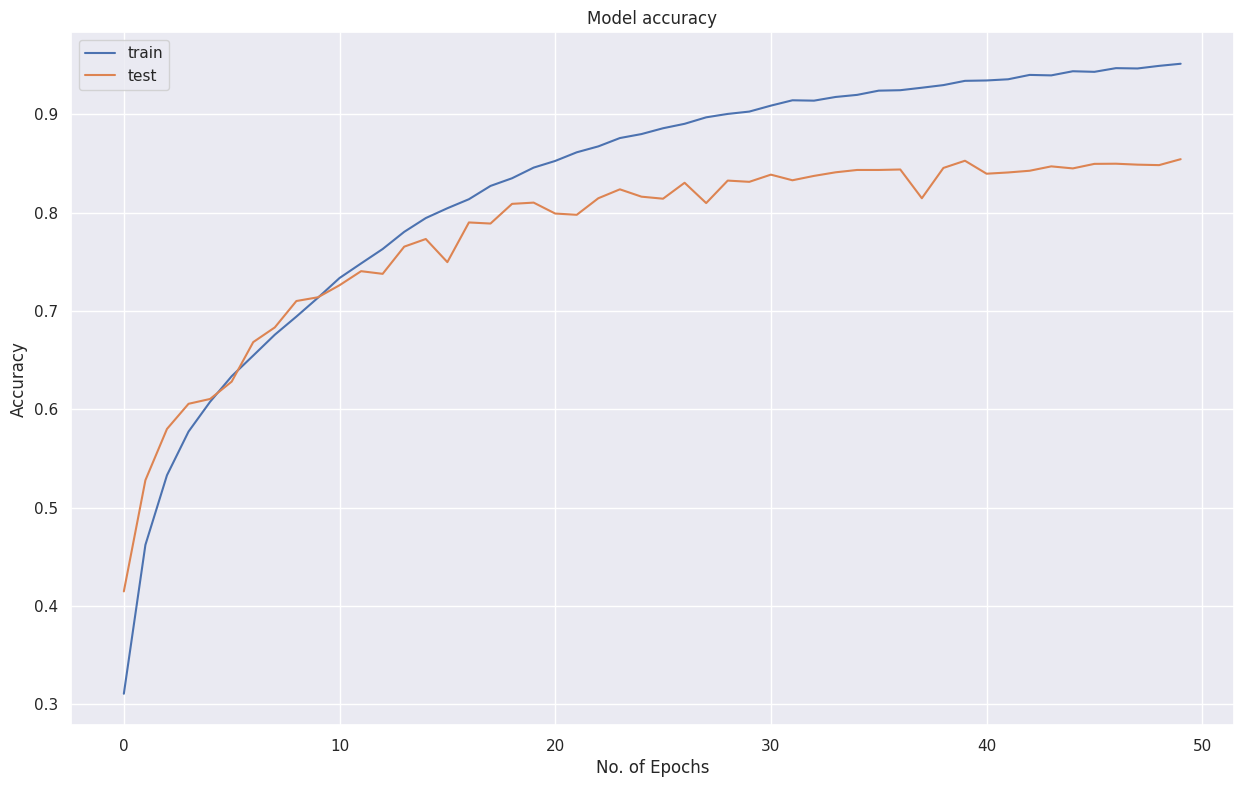

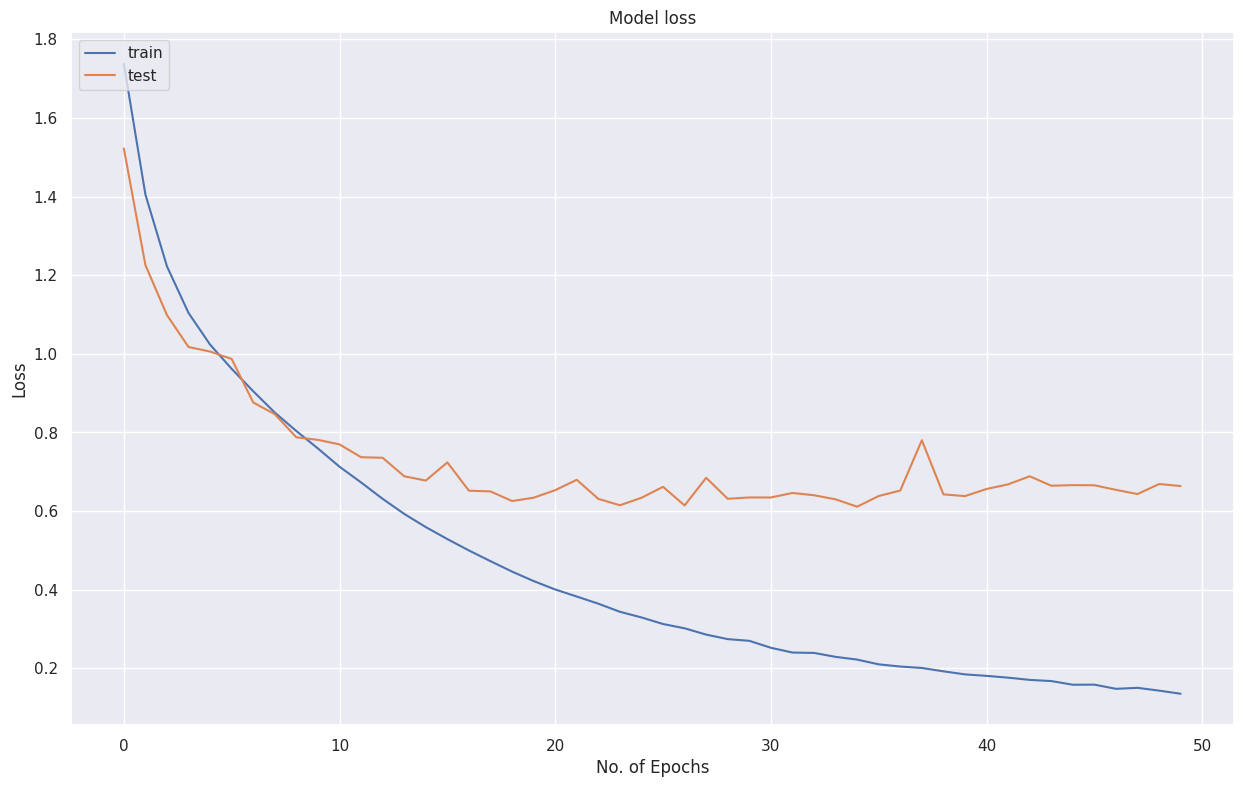

In [13]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [15]:
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib


In [29]:
import tensorflow as tf
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to capture photo
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize video element
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Function to preprocess and predict
def predict_image(image_path):
    # Load the best model
    model = load_model('/content/drive/MyDrive/best_model.h5')

    # Read the captured image
    img = cv2.imread(image_path)

    # Convert the image to grayscale (1 channel)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to the model's input size (48x48 input for the model)
    img_resized = cv2.resize(img_gray, (48, 48))  # Adjusting to 48x48 as per the model's requirement
    img_resized = img_resized.astype('float32') / 255.0

    # Add the channel dimension (1 channel for grayscale)
    img_resized = np.expand_dims(img_resized, axis=-1)

    # Add batch dimension
    img_resized = np.expand_dims(img_resized, axis=0)

    # Run the prediction
    prediction = model.predict(img_resized)
    predicted_class = np.argmax(prediction, axis=1)

    # Return the predicted class
    return predicted_class


# Capture image from webcam and predict
photo_filename = take_photo()
predicted_class = predict_image(photo_filename)

print("Predicted class:", predicted_class)


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
Predicted class: [6]
